In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import msgpack
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import midi_manipulation


%matplotlib inline

In [4]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in tqdm(files):
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [6]:
songs = get_songs('/Users/sdubnov/Documents/Courses/Mus 206 Deep & Shallow/Lab/Pop_Music_Midi/') #These songs have already been converted from midi to msgpack
print "{} songs processed".format(len(songs))

100%|██████████| 126/126 [00:08<00:00, 16.84it/s]

122 songs processed


In [7]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 16 #64 #32 #16 #This is the number of timesteps that we will create at a time  (16 = one bar)
n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
n_hidden       = 500 #50 #This is the size of the hidden layer

num_epochs = 20000 #The number of training epochs that we are going to run. For each epoch we go through the entire data set.
batch_size = 100 #The number of training examples that we are going to send through the model at a time. 
#lr         = tf.constant(0.005, tf.float32) #The learning rate of our model

In [8]:
x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer

In [9]:
z_dim = n_hidden #100
X_dim = n_visible #mnist.train.images.shape[1]
h_dim = n_hidden #128


In [10]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [11]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

In [12]:
def Q(X):
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

In [13]:
# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

Iter: 0
Loss: 2.332e+03
Iter: 1000
Loss: 95.44
Iter: 2000
Loss: 93.73
Iter: 3000
Loss: 97.4
Iter: 4000
Loss: 104.4
Iter: 5000
Loss: 57.31
Iter: 6000
Loss: 87.68
Iter: 7000
Loss: 72.66
Iter: 8000
Loss: 70.3
Iter: 9000
Loss: 77.0
Iter: 10000
Loss: 60.21
Iter: 11000
Loss: 88.27
Iter: 12000
Loss: 68.29
Iter: 13000
Loss: 63.51
Iter: 14000
Loss: 75.56
Iter: 15000
Loss: 57.88
Iter: 16000
Loss: 66.1
Iter: 17000
Loss: 51.97
Iter: 18000
Loss: 55.93
Iter: 19000
Loss: 71.38
Iter: 20000
Loss: 75.75


/Users/sdubnov/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


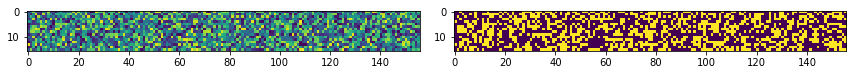

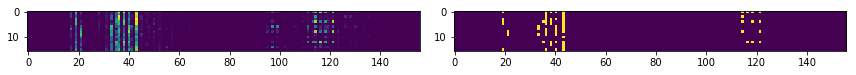

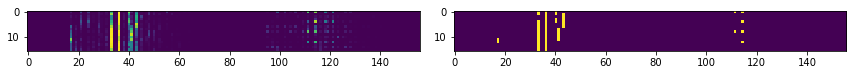

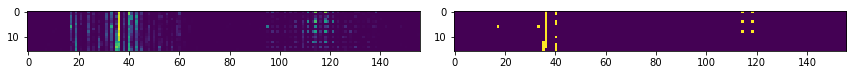

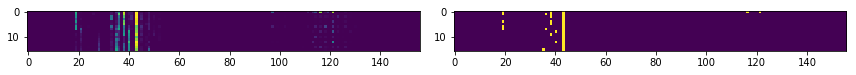

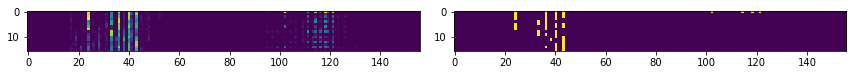

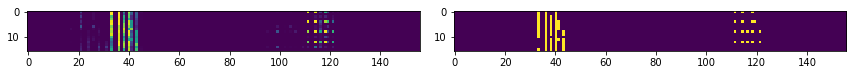

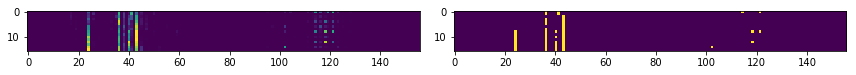

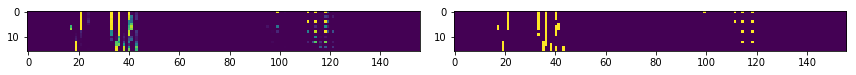

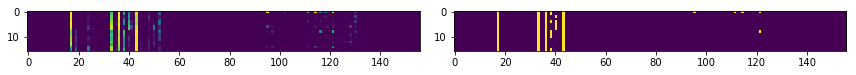

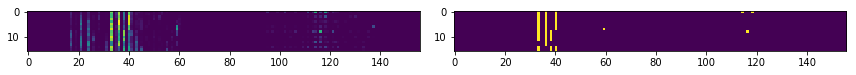

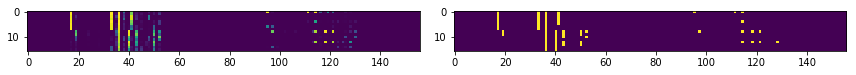

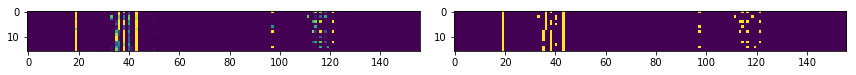

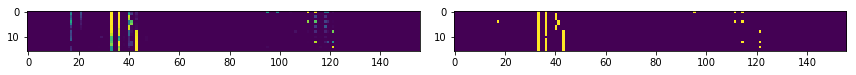

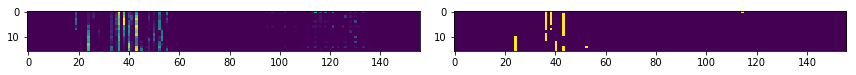

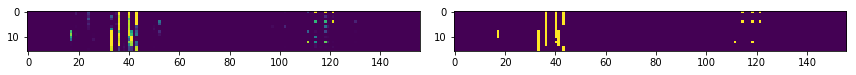

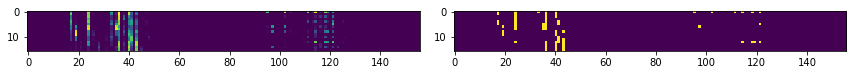

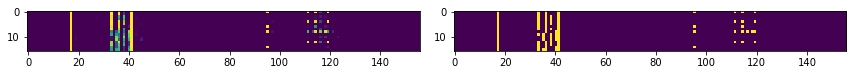

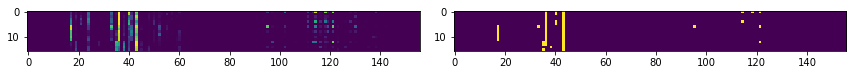

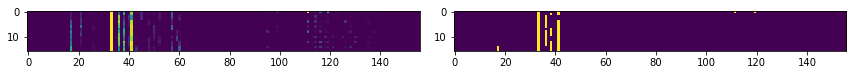

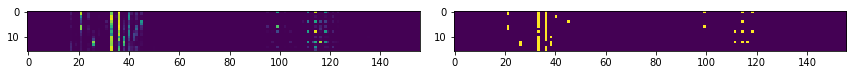

In [14]:
z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss) #check learning rate

#saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

while i <= num_epochs:
    for song in songs:
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
        song = np.reshape(song, [song.shape[0]/num_timesteps, song.shape[1]*num_timesteps])
        # Train the VAE on batch_size examples at a time
        for ind in range(1, len(song), batch_size): 
            X_mb = song[ind:ind+batch_size]
            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
    
            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                print('Loss: {:.4}'. format(loss))

                samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})

                S = np.reshape(samples, (num_timesteps, 2*note_range))
                thresh_S = S>=0.5
                plt.figure(figsize=(12,2))
                plt.subplot(1,2,1)
                plt.imshow(S)
                plt.subplot(1,2,2)
                plt.imshow(thresh_S)
                plt.tight_layout()
                plt.pause(0.1)
                midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
#                 print(i)
            i += 1


In [15]:
saver = tf.train.Saver()

#Save just in case
save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: /tmp/model.ckpt


In [16]:
#sess = tf.Session()
#saver.restore(sess, "out/model.ckpt")
#print("Model restored.")

In [17]:
bars = 60
samples = sess.run(X_samples, feed_dict={z: np.random.randn(bars,z_dim)})
S = np.reshape(samples, (bars*num_timesteps, 2*note_range))
thresh_S = S>=0.7 #0.5
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_long")

In [18]:
q = "./Naruto Shippuden OP 16 COMP - C maj.mid"
#q = "./tmprson3.mid"
#q = "./Naruto Shippuden OP 16 COMP.mid"
#q = "./Pop_Music_Midi/All The Small Things - Verse.midi"
querysong = np.array(midi_manipulation.midiToNoteStateMatrix(q))
print np.shape(querysong)

(1073, 156)


In [19]:
song = np.array(querysong)
song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
song = np.reshape(song, [song.shape[0]/num_timesteps, song.shape[1]*num_timesteps])
print np.shape(song)

(67, 2496)


In [21]:
# Encode the VAE on query
Xq = song
zq_mu, zq_logvar = sess.run([z_mu, z_logvar], feed_dict={X: Xq}) 
zq_sample = sess.run(z_sample, feed_dict={X: Xq}) 
#using the mean instead of sampling: 
#zq_sample = sess.run(z_mu, feed_dict={X: Xq})  #Check why this causes breaks / missing values in the output


In [22]:
# Decode with the z from query
samples = sess.run(X_samples, feed_dict={z: zq_sample})
decode_bars = np.shape(song)[0]
S = np.reshape(samples, (decode_bars*num_timesteps, 2*note_range))
thresh_S = S>=0.7 #0.5
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_query_h500_nt16")    

(67, 500)


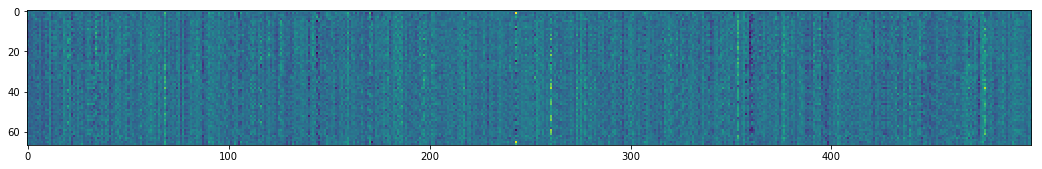

In [25]:
plt.figure(figsize=(18,5))
#plt.imshow(np.log(np.abs(zq_sample)))
plt.imshow(zq_mu)
print np.shape(zq_mu)

(67, 500)


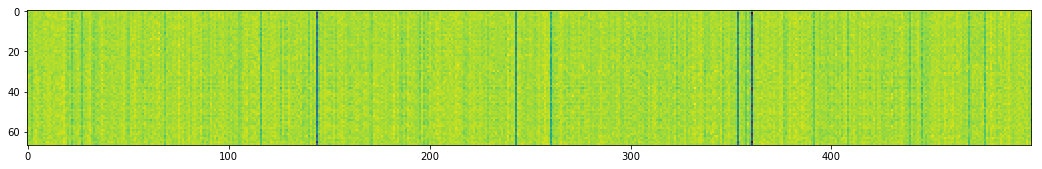

In [38]:
plt.figure(figsize=(18,5))
#plt.imshow(np.log(np.abs(zq_sample)))
plt.imshow(zq_logvar)
print np.shape(zq_mu)

# FINDING ORACLE FOR LATENT STATES
In the following cells we will use zq_sample as our features and try to find VMO to this data. The idea is to test if the feature learning aspect of VMO actually carries temporal information. The figure above has time as vertical and feature index as horizontal

In [27]:
import vmo
r = (0., 2.0, 0.01)
#ideal_t = vmo.find_threshold(zq_sample.T, r = r, dfunc = 'euclidean', dim=zq_sample.shape[0])
#ideal_t = vmo.find_threshold(zq_sample, r = r, dim=zq_sample.shape[1])
ideal_t = vmo.find_threshold(zq_mu, r = r, dim=zq_sample.shape[1])

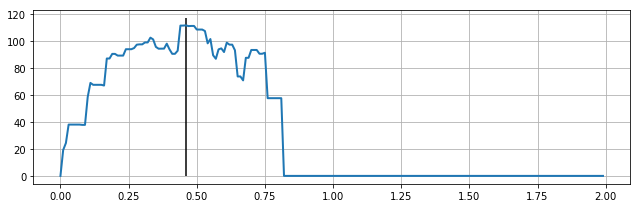

In [28]:
x_t = np.array([t[1] for t in ideal_t[1]])
y_t = [t[0] for t in ideal_t[1]] 
plt.figure(figsize = (9,3))
plt.plot(x_t, y_t, linewidth = 2)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t[0][1], 0, ymax)
plt.grid('on')
plt.tight_layout()

In [32]:
#best_zq_oracle = vmo.build_oracle(zq_sample, flag = 'a', threshold = ideal_t[0][1], dim=zq_sample.shape[1])
best_zq_oracle = vmo.build_oracle(zq_mu, flag = 'a', threshold = ideal_t[0][1], dim=zq_sample.shape[1])

### TO DO

right now the distance is measured between the means only. The feature vector shoud be the pair (mu, logvar)
here is what needs to be done-
1. create a combined (mu, logvar) feature 
2. add kl_loss as a distance measure in vmo

kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

here is a nice derivation of the kl distance for two Guassians
https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians


### IR for latent states as function of time
This gives a very high level qualitative impression about the way repetitions are detected. First there are new stuates with no repetitions, then two short repretitions and two longer ones (the hight shows IR value, which is proportional to the length of repeated block. Longer repeated blocks give higher IR).
This could be compared to IR of the original data to see if the signal itself has similar behavior. 

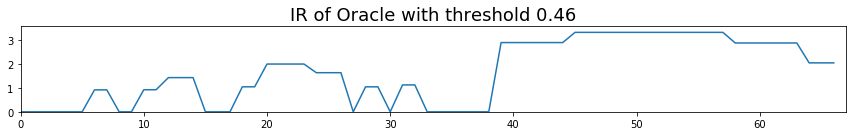

In [33]:
ir, h0, h1 = best_zq_oracle.IR()
plt.figure(figsize=(12,2))
plt.plot(ir)
plt.ylim((0, max(ir) + 0.25))
plt.xlim((0, len(ir)))
plt.title('IR of Oracle with threshold' + ' ' + str(ideal_t[0][1]), fontsize=18)
plt.tight_layout()

## trying to see if self-similairty matrixs can visually reveal the structure

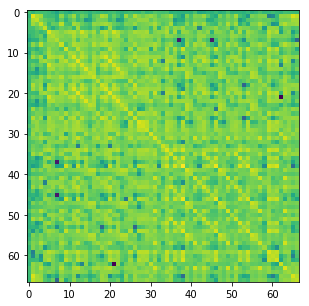

In [35]:
plt.figure(figsize=(5,5))
z_selfsim= np.matmul(zq_mu,zq_mu.T)
plt.imshow(np.log2(np.abs(z_selfsim)))

### Cross correlation between the latent variables. 
This is done to jsut to see if the latent dimensions are independent.

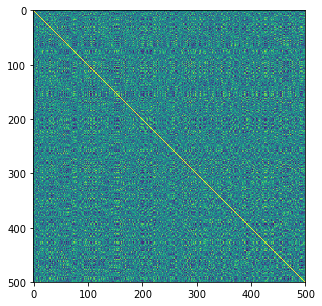

In [37]:
plt.figure(figsize=(5,5))
#z_corrmat= np.matmul(zq_sample.T,zq_sample)
z_corrmat= np.corrcoef(zq_mu.T)
plt.imshow(z_corrmat)

### Plotting the latent vectors statistics: Mean and Variance

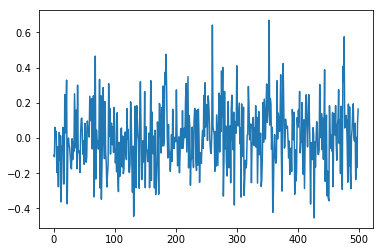

In [40]:
zq_mu = np.mean(zq_sample,axis = 0)
plt.plot(zq_mu)

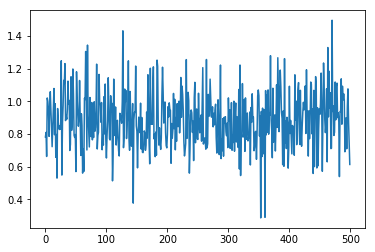

In [41]:
zq_sig2 = np.var(zq_sample,axis=0)
plt.plot(zq_sig2)

### Reducing the rate of latent states: 
The experiment is described in Mume paper. The idea is to control the information rate between the input and the latent state before passing it to the decoder. The idea of bit-allocation is used to have quantitative control of the amount of information, but basically the process removes latent dimensions that have little energy (variance) and adds noise to the other dimensions, depending on the total number of bits allowed. 

In [42]:
def reverse_water_filling(sigma2,bit_regime):
    bit_alloc = np.zeros(len(sigma2))
    tmp_s = 0
    tmp_s += sigma2
    for i in range(bit_regime):
        j = np.argmax(tmp_s)
        bit_alloc[j] += 1
        tmp_s[j] /= 4
    return bit_alloc

### Rate control:
Rate is the value allowing to control the noisy channel model of limiting information rate between latent states and input. See the Mume paper.

#### Note:
Here we replace the empirical variance computed from zq_sample with the zq_logvar feature.
We also average over all time steps to get the average variance for each channel

There are some open questions here:
1. there empirically derived zq_sig2 and the one below look different. Why? check / debug
2. change the bit allocation to be dynamic frame per frame. There is no reason to do an average bit allocation if we can switch between frames. 

It does seem from the graph of logvar over time that the variance does not change much, so at east for this data I do not expect much change, but potentially if the music changed and this is refected in changes to the latent states, the bit allocation trick could be a method to reveal that by focusing on the important high variance channels

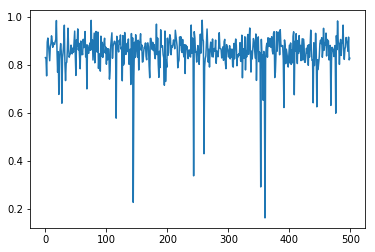

In [53]:
zq_sig2 = np.mean(np.exp(zq_logvar), axis = 0)
plt.plot(zq_sig2)

In [54]:
Rate = 256
bit_alloc = reverse_water_filling(zq_sig2,Rate)
#print(bit_alloc)
#print np.nonzero(bit_alloc)

In [55]:
#quant_zq = zq_sample[:,np.nonzero(bit_alloc)[0]]
#quant_zq = np.zeros(np.shape(zq_sample))
#quant_zq[:,np.nonzero(bit_alloc)[0]] = zq_sample[:,np.nonzero(bit_alloc)[0]]

chan_mumul = (1-np.power(2,-2*bit_alloc))

chan_eps = np.random.randn(*np.shape(zq_sample))
chan_sigmul = np.power(2,-4*bit_alloc)*(np.power(2,2*bit_alloc)-1)
#print chan_sigmul

#Assuming zero mean and unit variance for the encoder Z:
#quant_zq = np.matmul(zq_sample,np.diag(chan_mumul)) + np.matmul(chan_eps,np.diag(chan_sigmul)) 

#Using the actual mean and variance of the encoder Z:
quant_zq = np.matmul(zq_mu, np.diag(np.power(2,-2*bit_alloc))) + \
np.matmul(zq_sample,np.diag(chan_mumul)) + \
np.matmul(np.matmul(chan_eps,np.diag(chan_sigmul)),np.diag(zq_sig2))

### Comparison of the latent states before and after bit-allocation

Although we changed the orace creation above to use z_mu, the actual experiment of encoding / deconding did not change. We still need to use the sampling method from the reparametrization trick to create the decoding, and we apply the noisy channel / bit allocation trick to these latent variables before decoding. What it does open up as an interesting possibiility is using a query from vmo to find now longer sequences of latent feature from a query before the decoding samping phase is performed.

(67, 500) (67, 500)


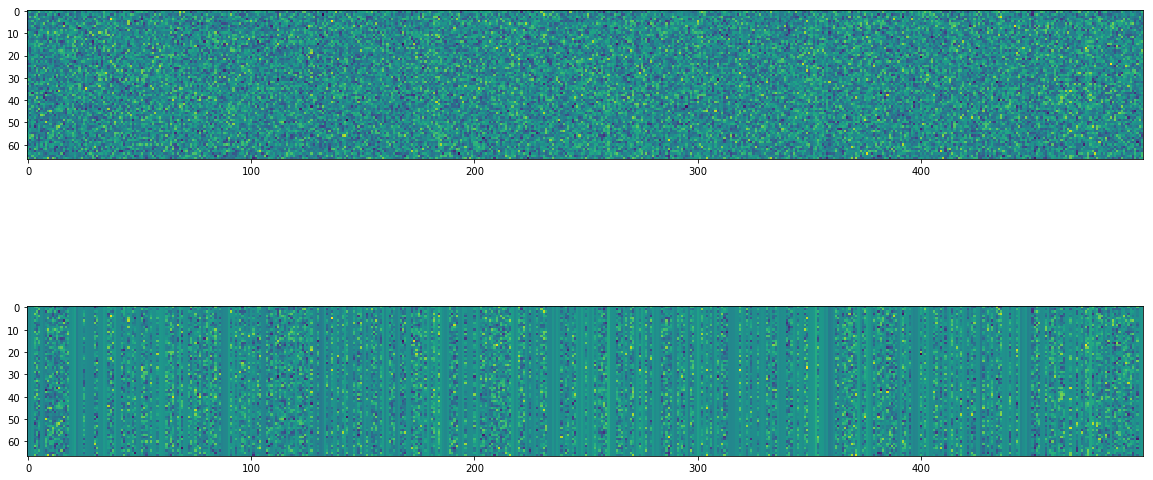

In [56]:
print np.shape(quant_zq), np.shape(zq_sample)
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(zq_sample)
plt.subplot(2,1,2)
plt.imshow(quant_zq)

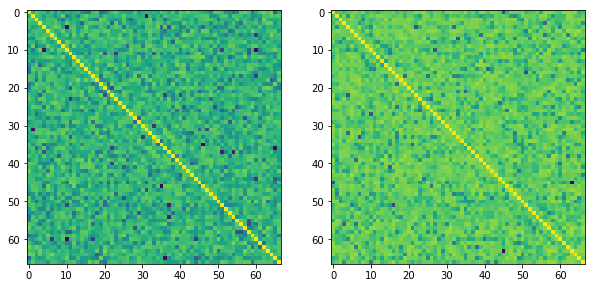

In [57]:
plt.figure(figsize=(10,10))


plt.subplot(1,2,1) 
z_selfsim= np.matmul(zq_sample,zq_sample.T)
plt.imshow(np.log2(np.abs(z_selfsim)))

plt.subplot(1,2,2) 
quant_z_selfsim= np.matmul(quant_zq,quant_zq.T)
plt.imshow(np.log2(np.abs(quant_z_selfsim)))

### The process of VMO modeling is repeated here for noisy (bit limited) version of latent states

In [35]:
import vmo
r = (0., 2.0, 0.01)
#ideal_t = vmo.find_threshold(quant_zq.T, r = r, dfunc = 'euclidean', dim=quant_zq.shape[0])
ideal_t = vmo.find_threshold(quant_zq, flag = 'a', r = r, dim=quant_zq.shape[1])

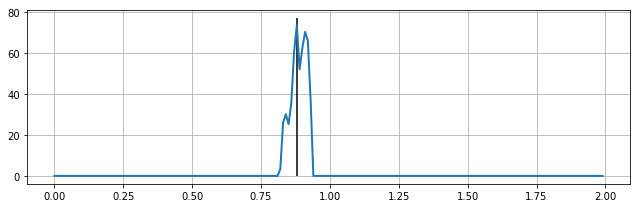

In [36]:
x_t = np.array([t[1] for t in ideal_t[1]])
y_t = [t[0] for t in ideal_t[1]] 
plt.figure(figsize = (9,3))
plt.plot(x_t, y_t, linewidth = 2)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t[0][1], 0, ymax)
plt.grid('on')
plt.tight_layout()

In [37]:
best_oracle = vmo.build_oracle(quant_zq, flag = 'a', threshold = ideal_t[0][1], dim=quant_zq.shape[1])

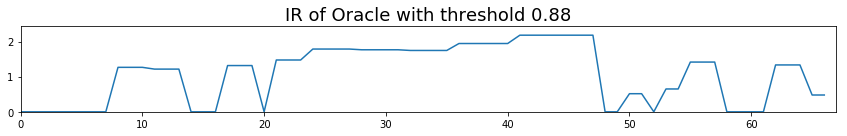

In [38]:
ir, h0, h1 = best_oracle.IR()
plt.figure(figsize=(12,2))
plt.plot(ir)
plt.ylim((0, max(ir) + 0.25))
plt.xlim((0, len(ir)))
plt.title('IR of Oracle with threshold' + ' ' + str(ideal_t[0][1]), fontsize=18)
plt.tight_layout()

In [39]:
# Decode with the z from query
#samples = sess.run(X_samples, feed_dict={z: zq_sample})
samples = sess.run(X_samples, feed_dict={z: quant_zq})
decode_bars = np.shape(song)[0]
S = np.reshape(samples, (decode_bars*num_timesteps, 2*note_range))
thresh_S = S>=0.7 #0.5
print Rate
fname = 'out/generated_query_h500_nt16_'+str(Rate)
midi_manipulation.noteStateMatrixToMidi(thresh_S,fname )    

256


In [197]:
help(vmo.build_oracle)

Help on function build_oracle in module vmo.VMO.oracle:

build_oracle(input_data, flag, threshold=0, suffix_method='inc', feature=None, weights=None, dfunc='cosine', dfunc_handle=None, dim=1)

